In [1]:
%load_ext tensorboard

In [3]:
import sys
sys.path.append('/home/loringm/proliferation-and-track')


from utils import convert_to_n5

import gunpowder as gp
import matplotlib.pyplot as plt
import numpy as np

import zarr

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
class Dataset_3DT(Dataset):
    def __init__(self, input_z_arr_path):
        ## expects zarr file with at least raw data
        
        self.input_z_arr_path = input_z_arr_path
        self.datasource = zarr.open(self.input_z_arr_path)
        self.dims = self.datasource['raw'].shape
        
        
        self.build_pipelines()
    
    
    def build_pipelines(self):
        
        self._raw = gp.ArrayKey('raw')
        self.raw_source = gp.ZarrSource(
            self.input_z_arr_path,  
            {self._raw: 'raw', }
        )
        
        self._ground_truth = gp.ArrayKey('GT')
        self.gt_source = gp.ZarrSource(
            self.input_z_arr_path,
            {self._ground_truth: 'GT', }
        )
        
        self._ground_truth_mask = gp.ArrayKey('GT_mask')
        self.gt_source_mask = gp.ZarrSource(
            self.input_z_arr_path,
            {self._ground_truth_mask: 'GT_mask', }
        )     
        
        self.comb_source = ((self.raw_source, self.gt_source ) + gp.MergeProvider())

        # random_location = gp.RandomLocation(mask=self._ground_truth_mask, min_masked=0.8)
        random_location = gp.RandomLocation()

        self.basic_request = gp.BatchRequest()
        self.basic_request[self._raw] = gp.Roi((0, 0, 0, 0), (1,16,256,256))
        self.basic_request[self._ground_truth] = gp.Roi((0, 0, 0, 0), (1,16,256,256))

        
        self.random_sample = self.comb_source + random_location

    
    def __getitem__(self):
        max_val = 0
        while max_val == 0:
    
            with gp.build(self.random_sample):
                  batch = self.random_sample.request_batch(self.basic_request)
            max_val = np.max(batch[self._ground_truth].data)
                        
        return batch[self._raw].data, batch[self._ground_truth].data

In [15]:
zarr_path = '/home/loringm/Downloads/SIMULATED_DATASET/01/data.n5'

In [16]:
ar = zarr.open(zarr_path)
ar.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='GT (150, 59, 349, 639…

In [18]:
ndata_path = '/home/loringm/Downloads/SIMULATED_DATASET/02'
ntest_path = '/home/loringm/Downloads/SIMULATED_DATASET/02_GT/SEG'

res = [1,1,1,1]

convert_to_n5(ndata_path, zarr_path, 'raw_test', res)
convert_to_n5(ntest_path, zarr_path, 'raw_test_GT', res)


100%|███████████████████████████████████████████| 80/80 [00:39<00:00,  2.03it/s]
/home/loringm/.conda/envs/kitty/lib/python3.7/site-packages/zarr/n5.py:711: RuntimeWarning: Not all N5 implementations support blosc compression (yet). You might not be able to open the dataset with another N5 library.
  RuntimeWarning
100%|███████████████████████████████████████████| 80/80 [00:09<00:00,  8.58it/s]


In [19]:
ar.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='GT (150, 59, 349, 639…

In [9]:
ar['raw'][:].max()

1023

In [11]:
data = ar['raw'][:]

In [14]:
np.histogram(data)

(array([1967053455,    6191991,     338869,      48586,      10404,
              2822,        821,        286,        100,         16]),
 array([  66. ,  161.7,  257.4,  353.1,  448.8,  544.5,  640.2,  735.9,
         831.6,  927.3, 1023. ]))

In [6]:
ar['GT_mask'] = np.array(ar['GT_mask'], dtype=np.int8)

/home/loringm/.conda/envs/kitty/lib/python3.7/site-packages/zarr/n5.py:711: RuntimeWarning: Not all N5 implementations support blosc compression (yet). You might not be able to open the dataset with another N5 library.
  RuntimeWarning


In [6]:
ar['GT_mask'].attrs['resolution'] = [1,1,1,1]

In [13]:
ar['GT'][0,50,:,:].max()

10

In [14]:
ar['GT'][0,0,:,:].max()

0

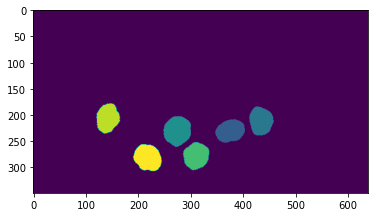

In [16]:
plt.imshow(ar['GT'][0,50,:,:])

In [7]:
zarr_path = '/home/loringm/Downloads/SIMULATED_DATASET/01/data.n5'

outputs = Dataset_3DT(zarr_path).__getitem__()

In [2]:
ar = zarr.open(zarr_path)

# ar['GT_mask'] = np.array(np.array(ar['GT'], dtype=bool), dtype='int8')


NameError: name 'zarr' is not defined

In [31]:
ar.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='GT (150, 59, 349, 639…

In [1]:
ar['mask']

NameError: name 'ar' is not defined

In [32]:
ar['GT']

<zarr.core.Array '/GT' (150, 59, 349, 639) uint16>

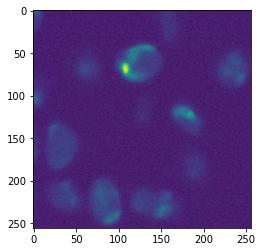

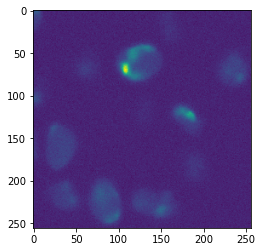

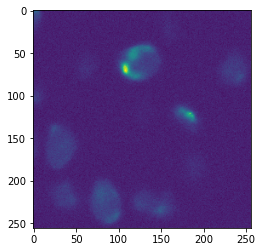

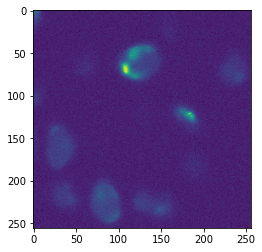

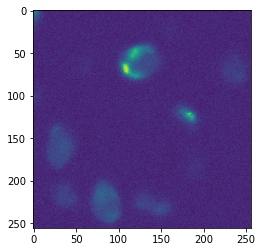

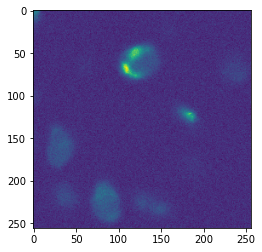

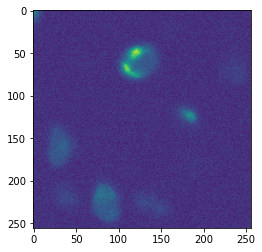

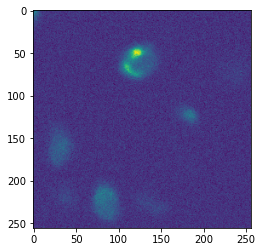

In [59]:
a,b = Dataset_3DT(zarr_path).__getitem__()

for i in range(a.shape[1]):
    plt.imshow(a[0,i,:,:])
    plt.show()

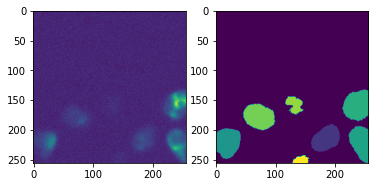

In [67]:
outputs = Dataset_3DT(zarr_path).__getitem__()
raw_img, gt_img = outputs

fig, ax = plt.subplots(1,2)

ax[0].imshow(raw_img[0,0,:,:])
ax[1].imshow(gt_img[0,5,:,:])

In [54]:
gt_img.max()

28

In [7]:
torch.unsqueeze(torch.Tensor(raw_img.astype(np.int16)), -1).shape

torch.Size([1, 32, 256, 256, 1])

In [8]:
class UNet3d(nn.Module):
    """ UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())       


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose3d(in_channels, out_channels,
                                kernel_size=2, stride=2)
    
    def __init__(self, in_channels=1, out_channels=1, 
                 final_activation=None):
        super().__init__()
        
        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = 4

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"
        
        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList
        
        # modules of the encoder path
        self.encoder = nn.ModuleList([self._conv_block(in_channels, 8),
                                      self._conv_block(8, 16),
                                      self._conv_block(16, 32),
                                      self._conv_block(32, 64)])
        # the base convolution block
        self.base = self._conv_block(64, 128)
        # modules of the decoder path
        self.decoder = nn.ModuleList([self._conv_block(128, 64),
                                      self._conv_block(64, 32),
                                      self._conv_block(32, 16),
                                      self._conv_block(16, 8)])
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool3d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList([self._upsampler(128, 64),
                                         self._upsampler(64, 32),
                                         self._upsampler(32, 16),
                                         self._upsampler(16, 8)])
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv3d(8, out_channels, 1)
        self.activation = final_activation
    
    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)
        
        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
        
        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x
    
class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        
    # the dice coefficient of two sets represented as vectors a, b ca be 
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        return (2 * intersection / denominator.clamp(min=self.eps))


In [9]:
def train(model, data_input, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, tb_logger=None):

    # set the model to train mode
    model.train()

    # move input and target to the active device (either cpu or gpu)
    x, y = data_input
    x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
    y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
    
    x, y = x.to(device), y.to(device)
    # print(x.shape)

    # zero the gradients for this iteration
    optimizer.zero_grad()

    # apply model and calculate loss
    prediction = model(x)
    loss = loss_function(prediction, y)

    # backpropagate the loss and adjust the parameters
    loss.backward()
    optimizer.step()
    
   # log to tensorboard
    if tb_logger is not None:
        step = epoch 
        tb_logger.add_scalar(tag='train_loss', scalar_value=loss.item(), global_step=step)
        # check if we log images in this iteration
#         if step % log_image_interval == 0:
#             tb_logger.add_images(tag='input', img_tensor=x.to('cpu'), global_step=step)
#             tb_logger.add_images(tag='target', img_tensor=y.to('cpu'), global_step=step)
#             tb_logger.add_images(tag='prediction', img_tensor=prediction.to('cpu').detach(), global_step=step)

In [10]:
def validate(model, data_input, loss_function, metric, epoc_l=None, step=None, tb_logger=None):
    # set model to eval mode
    model.eval()
    # running loss and metric values
    val_loss = 0
    val_metric = 0
    
    # disable gradients during validation
    with torch.no_grad():
        x, y = data_input
            
        x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
        y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
        
        # iterate over validation loader and update loss and metric values
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        val_loss += loss_function(prediction, y).item()
        val_metric += metric(prediction, y).item()

    # normalize loss and metric
    val_loss /= epoc_l
    val_metric /= epoc_l
    
    if tb_logger is not None:
        assert step is not None, "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag='val_loss', scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(tag='val_metric', scalar_value=val_metric, global_step=step)
        # we always log the last validation images
        # tb_logger.add_images(tag='val_input', img_tensor=x.to('cpu'), global_step=step)
        #tb_logger.add_images(tag='val_target', img_tensor=y.to('cpu'), global_step=step)
        #tb_logger.add_images(tag='val_prediction', img_tensor=prediction.to('cpu'), global_step=step)
        
    print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))

In [11]:
bce_loss = nn.BCEWithLogitsLoss()

In [12]:
assert torch.cuda.is_available()
device = torch.device("cuda")

In [13]:
# start a tensorboard writer
logger = SummaryWriter('runs/Unet')
%tensorboard --logdir runs

In [16]:
# build a default unet with sigmoid activation
# to normalize predictions to [0, 1]
net = UNet3d(1, 1, final_activation=nn.Sigmoid())
# move the model to GPU
net = net.to(device)

# use adam optimizer
optimizer = torch.optim.Adam(net.parameters())

# build the dice coefficient metric
metric = DiceCoefficient()

# train for 25 epochs
# during the training you can inspect the 
# predictions in the tensorboard
n_epochs = 50
for epoch in range(n_epochs):
    
    data_input = Dataset_3DT(zarr_path).__getitem__()

    # train
    train(net, data_input,
          optimizer=optimizer, loss_function=bce_loss,
          epoch=epoch, log_interval=5, tb_logger=logger)
    step = epoch 
    # validate
    validate(net, data_input, bce_loss, metric,
             step=step, tb_logger=logger, epoc_l=n_epochs)


Validate: Average loss: -0.1842, Average Metric: 0.0008




Validate: Average loss: -0.1073, Average Metric: 0.0009




Validate: Average loss: -0.0877, Average Metric: 0.0010




Validate: Average loss: 0.0149, Average Metric: 0.0041




Validate: Average loss: -0.0339, Average Metric: 0.0013




Validate: Average loss: -0.2740, Average Metric: 0.0006




Validate: Average loss: -0.1080, Average Metric: 0.0012




Validate: Average loss: -0.0785, Average Metric: 0.0007




Validate: Average loss: -0.2644, Average Metric: 0.0005




Validate: Average loss: -0.0186, Average Metric: 0.0008




Validate: Average loss: -0.0041, Average Metric: 0.0012




Validate: Average loss: -0.1345, Average Metric: 0.0008




Validate: Average loss: -0.0762, Average Metric: 0.0010




Validate: Average loss: -0.0314, Average Metric: 0.0013




Validate: Average loss: -0.1050, Average Metric: 0.0009




Validate: Average loss: -0.0120, Average Metric: 0.0020




Validate: Average loss: -0.1314, Average Metric: 0.0011




Validate: Average loss: -0.1468, Average Metric: 0.0006




Validate: Average loss: 0.0074, Average Metric: 0.0012




Validate: Average loss: 0.0253, Average Metric: 0.0014




Validate: Average loss: -0.1804, Average Metric: 0.0007




Validate: Average loss: 0.0258, Average Metric: 0.0005




Validate: Average loss: -0.1552, Average Metric: 0.0006




Validate: Average loss: 0.0152, Average Metric: 0.0036




Validate: Average loss: -0.1270, Average Metric: 0.0009




Validate: Average loss: -0.2772, Average Metric: 0.0004




Validate: Average loss: -0.4311, Average Metric: 0.0005




Validate: Average loss: 0.0063, Average Metric: 0.0024




Validate: Average loss: -0.0303, Average Metric: 0.0012




Validate: Average loss: -0.0344, Average Metric: 0.0020




Validate: Average loss: 0.0251, Average Metric: 0.0015




Validate: Average loss: 0.0039, Average Metric: 0.0011




Validate: Average loss: -0.0308, Average Metric: 0.0011




Validate: Average loss: -0.0107, Average Metric: 0.0013




Validate: Average loss: 0.0263, Average Metric: 0.0000




Validate: Average loss: -0.3161, Average Metric: 0.0005




Validate: Average loss: -0.3853, Average Metric: 0.0005




Validate: Average loss: -0.3812, Average Metric: 0.0005




Validate: Average loss: 0.0040, Average Metric: 0.0016




Validate: Average loss: 0.0235, Average Metric: 0.0037




Validate: Average loss: -0.1312, Average Metric: 0.0008




Validate: Average loss: -0.2201, Average Metric: 0.0007




Validate: Average loss: 0.0135, Average Metric: 0.0036




Validate: Average loss: -0.2195, Average Metric: 0.0008




Validate: Average loss: -0.0453, Average Metric: 0.0014




Validate: Average loss: 0.0215, Average Metric: 0.0030




Validate: Average loss: -0.0163, Average Metric: 0.0025




Validate: Average loss: -0.0194, Average Metric: 0.0008




Validate: Average loss: -0.3288, Average Metric: 0.0005


Validate: Average loss: -0.0405, Average Metric: 0.0015



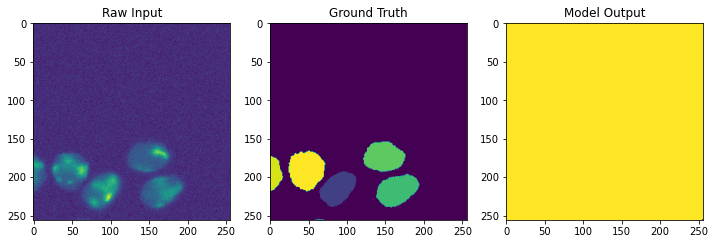

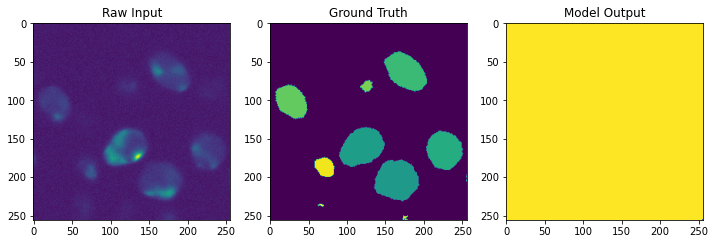

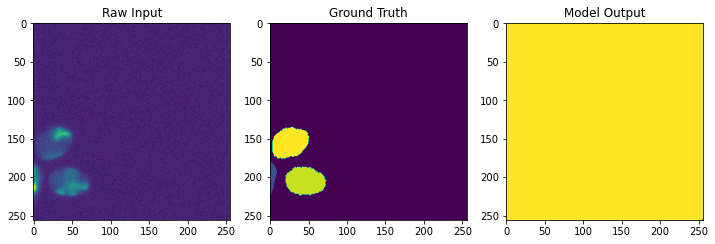

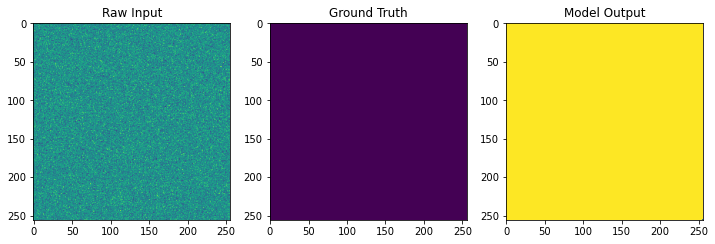

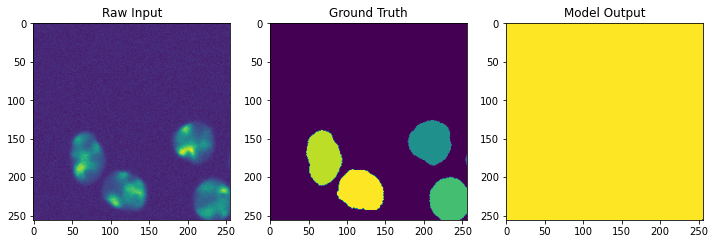

In [15]:
# plots some random comps from the model
with torch.no_grad():
    for i in range(5):
        data_input = Dataset_3DT(zarr_path).__getitem__()

        x, y = data_input
        x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
        y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
        
        x, y = x.to(device), y.to(device)
        
        raw = x
        true = y
        pred = net(x)

        fig, ax = plt.subplots(1,3, figsize=(12,12))
        ax[0].imshow(x.cpu().data.numpy()[0,0,5,:,:])
        ax[1].imshow(true.cpu().data.numpy()[0,0,5,:,:])
        ax[2].imshow(pred.cpu().data.numpy()[0,0,5,:,:])

        ax[0].set_title('Raw Input')
        ax[1].set_title('Ground Truth')
        ax[2].set_title('Model Output')
        plt.show()

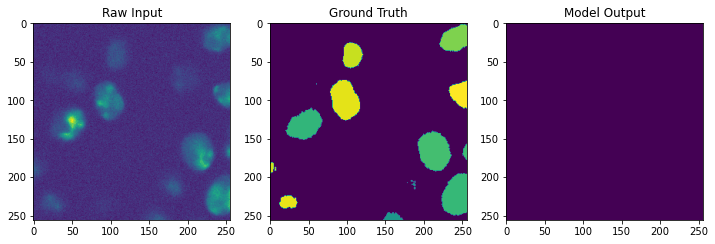

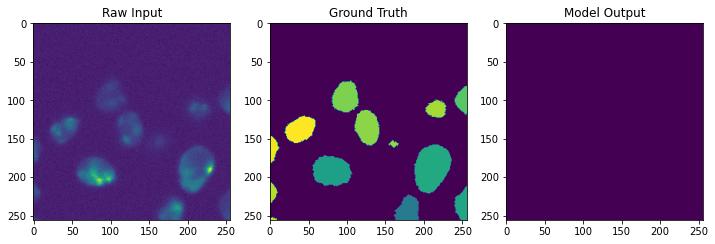

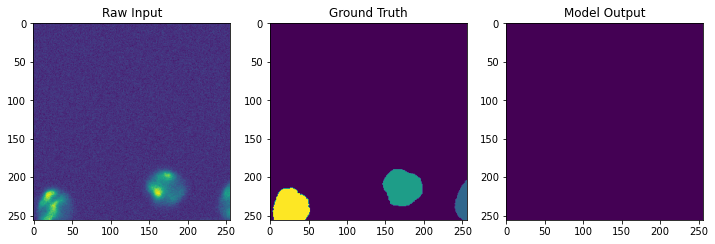

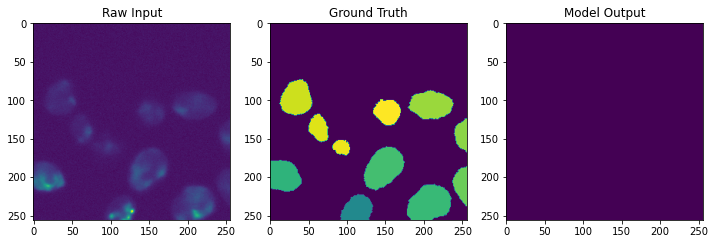

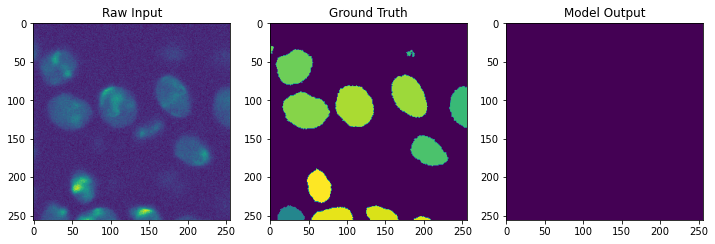

In [17]:
# plots some random comps from the model
with torch.no_grad():
    for i in range(5):
        data_input = Dataset_3DT(zarr_path).__getitem__()

        x, y = data_input
        x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
        y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
        
        x, y = x.to(device), y.to(device)
        
        raw = x
        true = y
        pred = net(x)

        fig, ax = plt.subplots(1,3, figsize=(12,12))
        ax[0].imshow(x.cpu().data.numpy()[0,0,5,:,:])
        ax[1].imshow(true.cpu().data.numpy()[0,0,5,:,:])
        ax[2].imshow(pred.cpu().data.numpy()[0,0,5,:,:])

        ax[0].set_title('Raw Input')
        ax[1].set_title('Ground Truth')
        ax[2].set_title('Model Output')
        plt.show()

In [265]:
def _conv_block(in_channels, out_channels):
    return nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
                         nn.ReLU(),
                         nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
                         nn.ReLU())    

_pooler = nn.MaxPool3d(2)

In [290]:
depth = 4

encoder = nn.ModuleList([_conv_block(1, 16),
                              _conv_block(16, 32),
                              _conv_block(32, 64),
                              _conv_block(64, 128)])

poolers = nn.ModuleList([nn.MaxPool3d(2) for _ in range(depth)])

In [293]:
data_input = Dataset_3DT(_zarr_path).__getitem__()
x,y = data_input 
x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
x, y = x.to(device), y.to(device)

In [ ]:
print(x.shape)

q = _conv_block(1,16)
q.to(device)

new_x = q(x)
print(new_x.shape)

q = _conv_block(16,32)
q.to(device)

new_x = q(new_x)
print(new_x.shape)

new_x = _pooler(new_x)
print('pooled to: ', new_x.shape)
## LETS POOL HERE ## 
## LETS POOL HERE ## 
new_x = _pooler(new_x)
print('pooled to: ', new_x.shape)


q = _conv_block(32,64)
q.to(device)

new_x = q(new_x)
print(new_x.shape)

q = _conv_block(64,128)
q.to(device)

new_x = q(new_x)
print(new_x.shape)

## LETS POOL HERE ## 
new_x = _pooler(new_x)
print('pooled to: ', new_x.shape)
## LETS POOL HERE ## 
new_x = _pooler(new_x)
print('pooled to: ', new_x.shape)

In [319]:
def _upsampler(in_channels, out_channels):
    return nn.ConvTranspose3d(in_channels, out_channels,
                            kernel_size=2, stride=2)

upsamplers = nn.ModuleList([_upsampler(256, 128),
                                 _upsampler(128, 64),
                                 _upsampler(64, 32),
                                 _upsampler(32, 16)])

## DECODER
decoder = nn.ModuleList([_conv_block(256, 128),
                              _conv_block(128, 64),
                              _conv_block(64, 32),
                              _conv_block(32, 16)])

In [324]:
data_input = Dataset_3DT(_zarr_path).__getitem__()
x,y = data_input 
x =  torch.unsqueeze(torch.Tensor(x.astype(np.int16)), 0)
y =  torch.unsqueeze(torch.Tensor(y.astype(np.int16)), 0)
x, y = x.to(device), y.to(device)

encoder_out = []
for level in range(depth):
    x = encoder[level].to(device)(x)
    print(x.shape)
    encoder_out.append(x)
    x = poolers[level].to(device)(x)
    print(x.shape)
    
x = _conv_block(128, 256).to(device)(x)
print('ENCODED')

encoder_out = encoder_out[::-1]

for level in range(depth):
    x = upsamplers[level].to(device)(x)
    print(x.shape)
    x = decoder[level].to(device)(torch.cat((x, encoder_out[level].to(device)), dim=1))
print('DECODED')

torch.Size([1, 16, 32, 256, 256])
torch.Size([1, 16, 16, 128, 128])
torch.Size([1, 32, 16, 128, 128])
torch.Size([1, 32, 8, 64, 64])
torch.Size([1, 64, 8, 64, 64])
torch.Size([1, 64, 4, 32, 32])
torch.Size([1, 128, 4, 32, 32])
torch.Size([1, 128, 2, 16, 16])
ENCODED
torch.Size([1, 128, 4, 32, 32])
torch.Size([1, 64, 8, 64, 64])
torch.Size([1, 32, 16, 128, 128])
torch.Size([1, 16, 32, 256, 256])
DECODED
